## Data Modeling
- Model Task is binary Classification
- Data Preprocessing
- Data Augmentation
    - Undersampling
    - SMOTE
- Data Split
    - Stratified 6:2:2
    - K-fold cv
- Modeling
    - Xgboost
    - Random forest
-Evaluation
    - precision, recall
    - marco-f1-score, accuracy
    - AU - PRC

### Data Class 나누기
- Fully Paid : 1497783
- Default(Charged Off + Default) : 362981

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [3]:
## Load original data
data_path = "Dataset/loan_data.csv"
data = pd.read_csv(data_path, low_memory=False)

In [5]:
"""data_path = "Dataset/Loan_status_2007-2020Q3.gzip"
data = pd.read_csv(data_path, low_memory=False)"""

'data_path = "Dataset/Loan_status_2007-2020Q3.gzip"\ndata = pd.read_csv(data_path, low_memory=False)'

In [6]:
"""address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
data.to_csv(path_or_buf=address+"loan_data.csv", index=False)"""

'address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"\ndata.to_csv(path_or_buf=address+"loan_data.csv", index=False)'

In [4]:
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [5]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.
mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}

def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan

# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

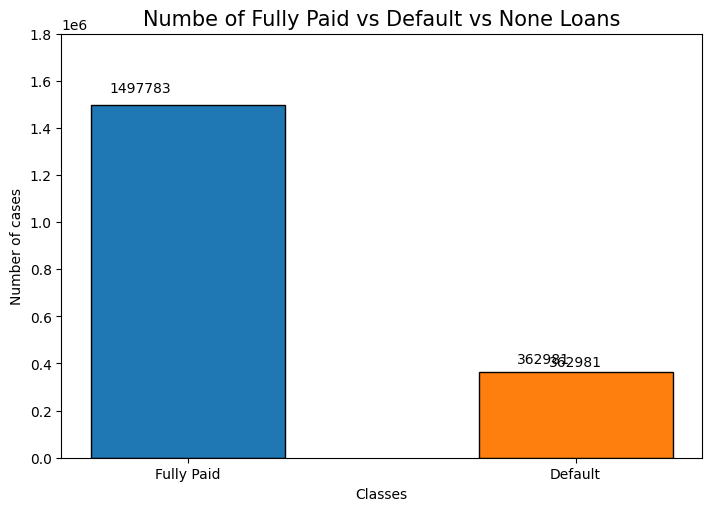

In [6]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [7]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126339946167981


### Feature preprocessing
- drop 할 것들 drop (정답과 거의 동일 시시)
    - `total_pymnt`: 지금까지 상환한 총 금액
    - `total_pymnt_inv`: 투자자 기준 상환 금액
    - `out_prncp`, `out_prncp_inv`: **남은 원금** (완납 시 0, 연체 시 잔액 있음) → **loan_status 직접 반영**
    - `recoveries`: 연체 시 회수된 금액 → 연체나 대손 시 값이 나타남
    - `collection_recovery_fee`: 회수 비용 → 연체 상태와 직접 관련
    - `last_pymnt_d`: 마지막 상환 날짜 → **완납 여부를 바로 알 수 있음**
    - `last_pymnt_amnt` : 마지막 상환 금액 → 연체 시 0일 가능성 높음
    - `issue_d`: 대출 발급 날짜 → 대출 상태와 시간적 연관성
    - `next_pymnt_d`: 다음 상환 예정일 → 연체 시 값이 비어 있거나 지연됨
    - `last_credit_pull_d`: 신용 조회일 → 연체 시 조회 빈도 증가 가능
    - 'total_rec_prncp',      # 상환된 원금 → 정답 직접 암시
    - 'total_rec_int',        # 상환된 이자 → 상환 여부 직접 반영
    - 'total_rec_late_fee',   # 연체 수수료 상환 → 연체 여부 직접 알려줌
    - 'last_fico_range_high', # fico 신용점수 상한가
    - 'last_fico_range_low'   # fico 신용점수 하한가
- drop : Unique key인 변수, 문장 데이터인 경우
- specific feature 변수 변환

In [8]:
#feature drop
drop_features = ['Unnamed: 0','purpose', 'title','id', 'pymnt_plan', 'policy_code','url']
drop_data_leakage = ['total_pymnt','total_pymnt_inv','out_prncp',
                     'out_prncp_inv','recoveries','collection_recovery_fee',
                     'last_pymnt_d','last_pymnt_amnt','issue_d',
                     'next_pymnt_d','last_credit_pull_d','total_rec_prncp', 
                    'total_rec_int','total_rec_late_fee','last_fico_range_high',
                    'last_fico_range_low'
                     ]
data = data.drop(columns=drop_features + drop_data_leakage)

In [9]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

print(len(data_x.columns))

118


In [10]:
#data 타입 변환
#퍼센트를 float형태로 바꾸기
def converting_cat_to_num(x):
    if not isinstance(x,str):
        return x  
    return float(x.split("%")[0].lstrip())

#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])

def to_data_tranfromer(x):
    if not isinstance(x, str):
        return np.nan
    date = x.split('-')
    if len(date) != 2:
        return np.nan  # 예상치 못한 포맷 처리
    month, year = date[0], date[1]
    return int(year + enum.get(month, "00"))  # "YYYYMM" 형식으로 변환

## 시간 데이터 확인
to_data_features = ["earliest_cr_line",  \
                    "sec_app_earliest_cr_line", "hardship_start_date",\
                    "hardship_end_date", "payment_plan_start_date"]

enum = {'Jan':"01", 'Feb':"02", 'Mar':"03", 
        'Apr':"04", 'May':"05", 'Jun':"06",
        'Jul':"07", 'Aug':"08", 
        'Sep':"09", 'Oct':"10", 
        'Nov':"11", 'Dec':"12"}

# Converting numerically data stored as categorical
data_x['int_rate'] = data_x['int_rate'].map(converting_cat_to_num)
data_x['revol_util'] = data_x['revol_util'].map(converting_cat_to_num)

# Filtering the zip code
data_x["zip_code"] = data_x["zip_code"].map(filter_zip_code)


for name in to_data_features:
    data_x[name] = data_x[name].map(to_data_tranfromer)

print("Successfully converted!")

Successfully converted!


In [11]:
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = data_x.columns
#columns_name_to_check = columns_name_to_check.drop("loan_status")
# Calculating
for name in columns_name_to_check:
    number_of_nulls = data_x[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(data_x[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (data_x[name].count() - data_x[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/data_x[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,1859196,0.999157
35,acc_now_delinq,0,0.000000,1860756,0.999996
31,application_type,0,0.000000,1860762,0.999999
28,initial_list_status,0,0.000000,1860762,0.999999
27,total_acc,0,0.000000,1860615,0.999920
25,revol_bal,0,0.000000,1766468,0.949324
24,pub_rec,0,0.000000,1860722,0.999977
23,open_acc,0,0.000000,1860678,0.999954
19,fico_range_high,0,0.000000,1860724,0.999979
18,fico_range_low,0,0.000000,1860724,0.999979


In [12]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    data_x.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 53
Non-high presence features have been deleted successfully!


In [13]:
print(f"The number of features : {len(data_x.columns)}\nThe target feature : {data_y.columns}")

The number of features : 65
The target feature : Index(['loan_status'], dtype='object')


### Handle Missing Value
- Drop 데이터를 어차피 180만개 중에서 10만개만 사라진다.

In [14]:
data_t = pd.concat([data_x, data_y], axis = 1)

In [40]:
print(f"Before drop: {data_x.shape[0]} samples")
data_x_cleaned = data_t.dropna()

data_x = data_x_cleaned.drop(columns='loan_status')
data_y = data_x_cleaned[['loan_status']]

print(f"After drop: {data_x.shape[0]} samples")

Before drop: 1860764 samples
After drop: 1761129 samples


### Label Encoding

In [41]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

Encoded data_x sample:
        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
42536    12000.0      12000.0          12000.0     0     10.99       392.81   
42537     4800.0       4800.0           4800.0     0     10.99       157.13   
42538    27050.0      27050.0          27050.0     0     10.99       885.46   
42539    12000.0      12000.0          12000.0     0      7.62       373.94   
42540    14000.0      14000.0          14000.0     0     12.85       470.71   

       grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
42536      1          6               5     60000.0  ...           100.0   
42537      1          6               1     39600.0  ...           100.0   
42538      1          6               4     55000.0  ...           100.0   
42539      0          2               1     96500.0  ...           100.0   
42540      1          8               5     88000.0  ...            78.6   

       percent_bc_gt_75  pub_rec_bankruptcie

### Augmentation
- Undersampling
- TableGan 

#### Undersampling

In [19]:
data_total = pd.concat([data_x, data_y], axis=1)

In [20]:
# Feature와 Target 분리
X = data_total.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_total[['loan_status']]  # Target (타겟 변수)

# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {X.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=X.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1415301
1               345828
Name: count, dtype: int64
Original data size: 1761129 samples
Undersampled data size: 691656 samples

Undersampling imbalance check
loan_status
0    345828
1    345828
Name: count, dtype: int64


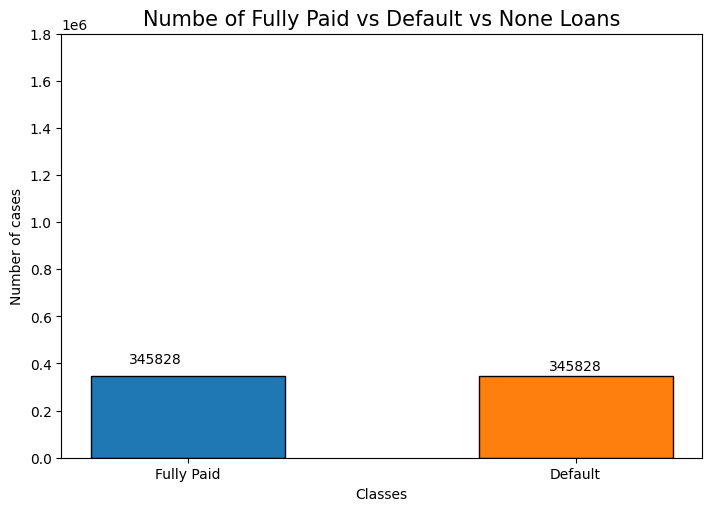

In [21]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

In [22]:
import pandas as pd

# 1️⃣ 상관관계 계산
# numeric_only=True 옵션은 숫자형 컬럼에 대해서만 상관관계를 계산합니다.
correlation_matrix = data_under.corr(numeric_only=True)['loan_status'].sort_values(ascending=False)

# 2️⃣ 상관관계 표 생성
correlation_df = correlation_matrix.to_frame(name='Correlation_with_loan_status')

# 3️⃣ 절대값 기준 정렬 (상관관계 강도가 높은 순서)
correlation_df['Absolute_Correlation'] = correlation_df['Correlation_with_loan_status'].abs()
correlation_df = correlation_df.sort_values(by='Absolute_Correlation', ascending=False)

# 4️⃣ 상관관계 표 출력
print("🔎 Feature와 loan_status 간 상관관계:")
print(correlation_df.head(10))


🔎 Feature와 loan_status 간 상관관계:
                      Correlation_with_loan_status  Absolute_Correlation
loan_status                               1.000000              1.000000
sub_grade                                 0.314307              0.314307
int_rate                                  0.305934              0.305934
grade                                     0.305665              0.305665
debt_settlement_flag                      0.279940              0.279940
term                                      0.200989              0.200989
fico_range_low                           -0.158490              0.158490
fico_range_high                          -0.158488              0.158488
acc_open_past_24mths                      0.114804              0.114804
verification_status                       0.103895              0.103895


In [23]:
X = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_under[['loan_status']]  # Target (타겟 변수)

In [24]:
# data under 6:2:2 train,val,test set

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")

Train size: 414993 samples (60.0%)
Validation size: 138331 samples (20.0%)
Test size: 138332 samples (20.0%)


### Min - Max Scaling

In [25]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
2226926   0.102564     0.102564         0.108848   0.0  0.182243     0.078987   
1529390   0.334615     0.334615         0.339274   1.0  0.610592     0.208418   
2021762   0.743590     0.743590         0.745385   0.0  0.100467     0.538958   
327960    0.179487     0.179487         0.185232   0.0  0.341511     0.145516   
2427879   0.179487     0.179487         0.185232   0.0  0.127726     0.133171   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
2226926  0.166667   0.205882             1.0    0.000327  ...           0.941   
1529390  0.666667   0.676471             1.0    0.000364  ...           0.914   
2021762  0.000000   0.117647             1.0    0.001091  ...           1.000   
327960   0.333333   0.352941             1.0    0.000227  ...           1.000   
2427879  0.000000   0.117647             1.0    0.000409  ...           1.000   

   

### Undersampling 진행한 경우 
- Model Xgboost

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

[0]	validation_0-logloss:0.69197	validation_1-logloss:0.69199
[1]	validation_0-logloss:0.69011	validation_1-logloss:0.69015
[2]	validation_0-logloss:0.68829	validation_1-logloss:0.68833
[3]	validation_0-logloss:0.68650	validation_1-logloss:0.68656
[4]	validation_0-logloss:0.68474	validation_1-logloss:0.68481
[5]	validation_0-logloss:0.68302	validation_1-logloss:0.68310
[6]	validation_0-logloss:0.68134	validation_1-logloss:0.68143
[7]	validation_0-logloss:0.67971	validation_1-logloss:0.67982
[8]	validation_0-logloss:0.67808	validation_1-logloss:0.67820
[9]	validation_0-logloss:0.67648	validation_1-logloss:0.67661
[10]	validation_0-logloss:0.67494	validation_1-logloss:0.67508
[11]	validation_0-logloss:0.67395	validation_1-logloss:0.67411
[12]	validation_0-logloss:0.67245	validation_1-logloss:0.67262
[13]	validation_0-logloss:0.67095	validation_1-logloss:0.67113
[14]	validation_0-logloss:0.66948	validation_1-logloss:0.66967
[15]	validation_0-logloss:0.66807	validation_1-logloss:0.66827
[1

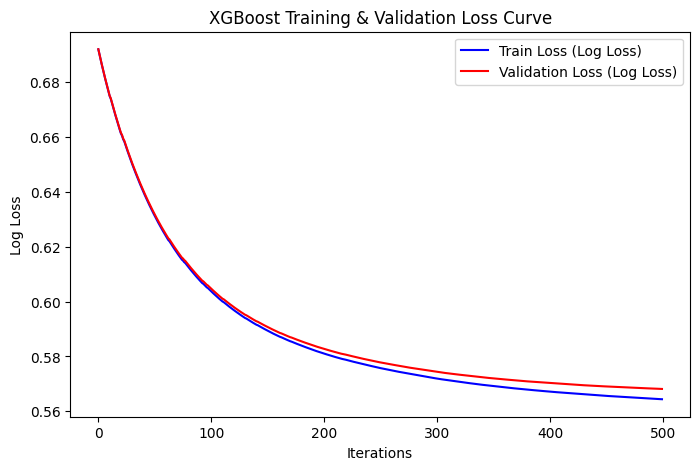

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69     69166
           1       0.70      0.66      0.68     69166

    accuracy                           0.69    138332
   macro avg       0.69      0.69      0.69    138332
weighted avg       0.69      0.69      0.69    138332



In [29]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

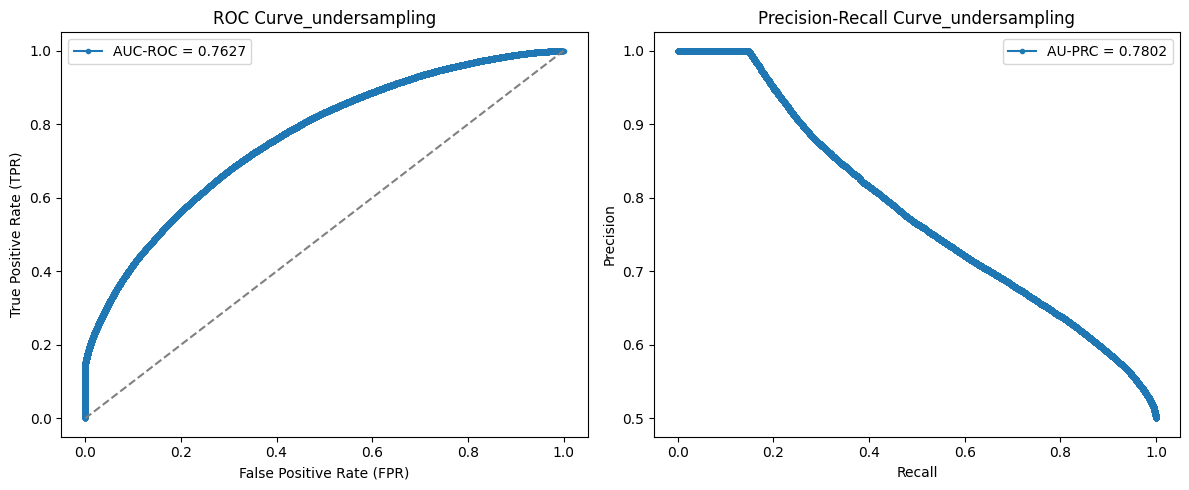

In [30]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

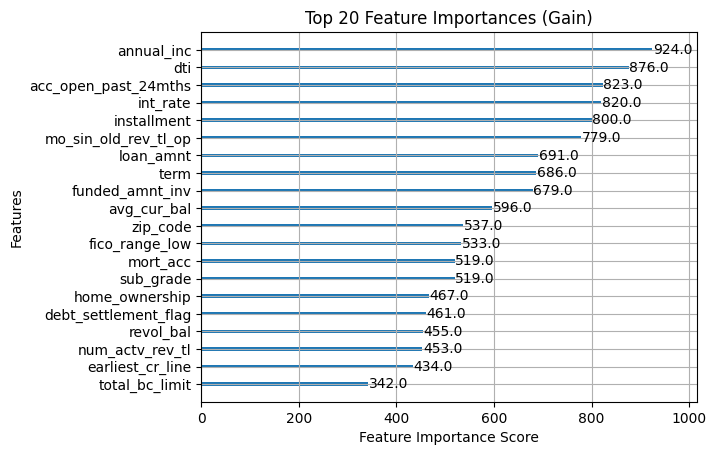

In [31]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

### Base 
- Augmentation 진행 하지 않은 경우
- model XGBoost

In [32]:
data_orinal = data_total.copy()

In [33]:
# data under 6:2:2 train,val,test set

X = data_orinal.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_orinal[['loan_status']]  # Target (타겟 변수)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_orinal):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_orinal):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_orinal):.1%})")

Train size: 1056677 samples (60.0%)
Validation size: 352226 samples (20.0%)
Test size: 352226 samples (20.0%)


In [34]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1944852   0.128205     0.128205         0.134309   0.0  0.182243     0.105269   
619286    0.358974     0.358974         0.363463   1.0  0.166277     0.176812   
2303828   0.230769     0.230769         0.236155   0.0  0.172897     0.180259   
359557    0.102564     0.102564         0.108211   0.0  0.198988     0.086949   
830396    0.308974     0.308974         0.313813   1.0  0.223520     0.158317   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1944852  0.166667   0.205882             0.2    0.004091  ...           0.812   
619286   0.166667   0.147059             0.8    0.002091  ...           1.000   
2303828  0.166667   0.205882             0.8    0.004909  ...           0.957   
359557   0.166667   0.205882             1.0    0.002727  ...           1.000   
830396   0.166667   0.235294             0.2    0.004546  ...           1.000   

   

In [35]:
# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

[0]	validation_0-logloss:0.49768	validation_1-logloss:0.49769
[1]	validation_0-logloss:0.49599	validation_1-logloss:0.49598
[2]	validation_0-logloss:0.49435	validation_1-logloss:0.49434
[3]	validation_0-logloss:0.49275	validation_1-logloss:0.49274
[4]	validation_0-logloss:0.49121	validation_1-logloss:0.49119
[5]	validation_0-logloss:0.48971	validation_1-logloss:0.48968
[6]	validation_0-logloss:0.48826	validation_1-logloss:0.48823
[7]	validation_0-logloss:0.48686	validation_1-logloss:0.48682
[8]	validation_0-logloss:0.48548	validation_1-logloss:0.48544
[9]	validation_0-logloss:0.48414	validation_1-logloss:0.48409
[10]	validation_0-logloss:0.48285	validation_1-logloss:0.48279
[11]	validation_0-logloss:0.48220	validation_1-logloss:0.48215
[12]	validation_0-logloss:0.48095	validation_1-logloss:0.48089
[13]	validation_0-logloss:0.47972	validation_1-logloss:0.47965
[14]	validation_0-logloss:0.47851	validation_1-logloss:0.47844
[15]	validation_0-logloss:0.47735	validation_1-logloss:0.47727
[1

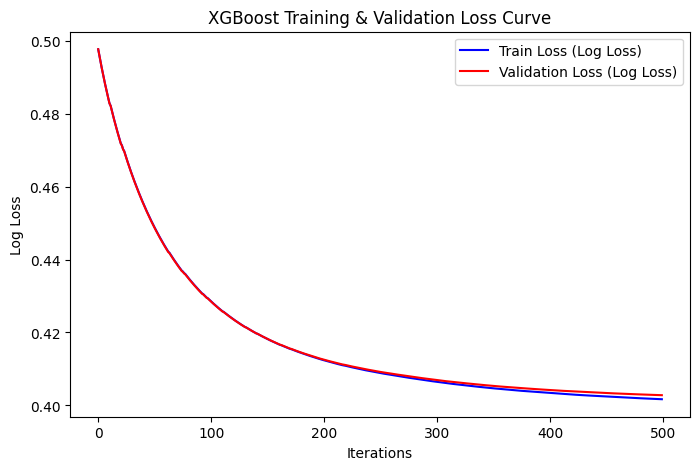

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    283061
           1       0.92      0.17      0.29     69165

    accuracy                           0.83    352226
   macro avg       0.87      0.58      0.60    352226
weighted avg       0.85      0.83      0.78    352226



In [36]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

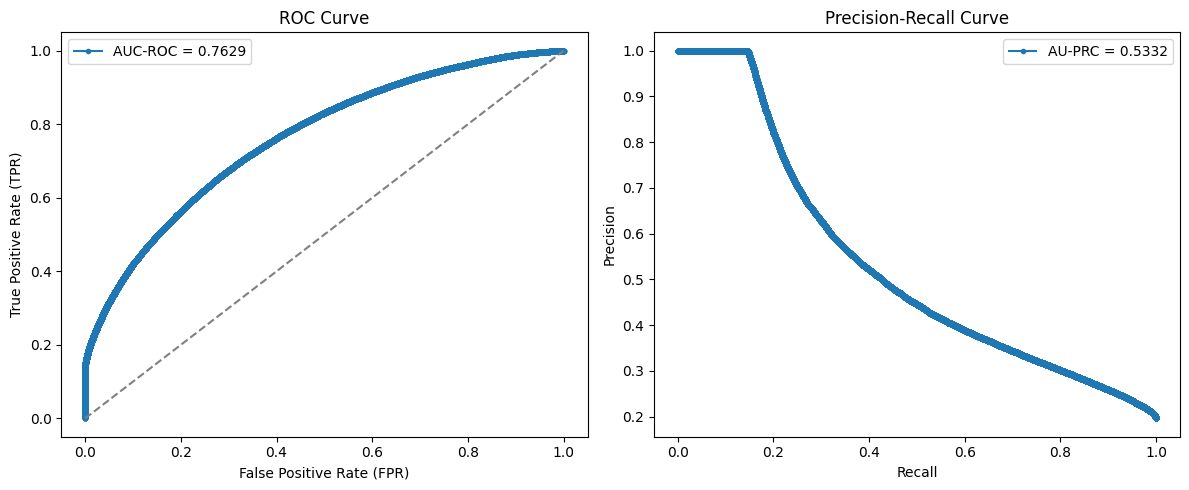

In [38]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

In [ ]:
"""pip list --format=freeze > requirements.txt"""

Note: you may need to restart the kernel to use updated packages.


### TableGAN

In [16]:
## Load Tablegan fake data 
fake_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/defalut_original/defalut_original_OI_11_00_fake_50K.csv"
fake_data = pd.read_csv(fake_data_path,low_memory=False)

fake_data["loan_status"] = 1

In [19]:
data_x = data_t.drop(columns='loan_status')
data_y = data_t[['loan_status']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_t):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_t):.1%})")

Train size: 1488611 samples (80.0%)
Test size: 372153 samples (20.0%)


In [21]:
data_t3 = pd.concat([X_train, y_train], axis = 1)

In [23]:
data_t2 = pd.concat([data_t3, fake_data])

In [25]:
test_data = pd.concat([X_test,y_test], axis=1)

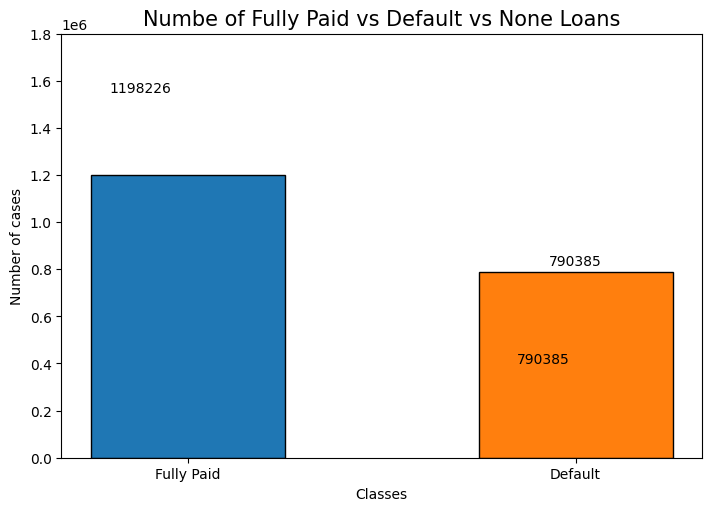

In [24]:
# Visualizing the encoded target

defalut_fully_paid = data_t2['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

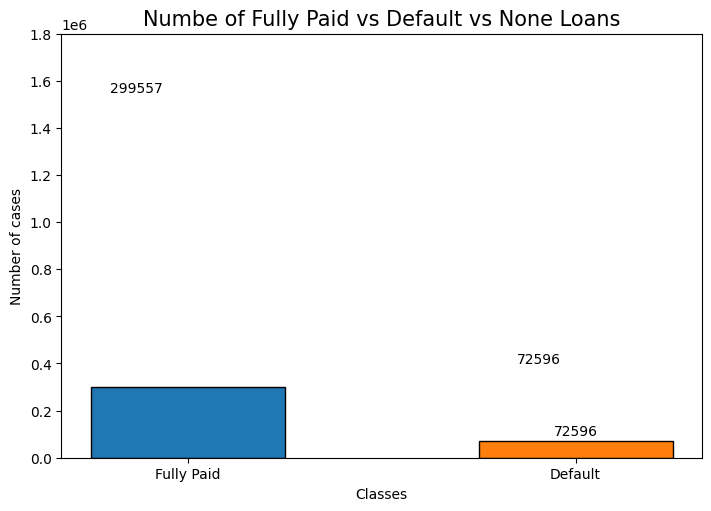

In [26]:
# Visualizing the encoded target, Test data

defalut_fully_paid = test_data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

#### Handle Missing value

In [27]:
print(f"Before drop: {data_t2.shape[0]} samples")
data_x_cleaned = data_t2.dropna()
test_data_cleaned = test_data.dropna()

data_x = data_x_cleaned.drop(columns='loan_status')
data_y = data_x_cleaned[['loan_status']]

X_test = test_data_cleaned.drop(columns = 'loan_status')
y_test = test_data_cleaned[['loan_status']
                           ]
print(f"After drop: {data_x.shape[0]} samples")

Before drop: 1988611 samples
After drop: 1908741 samples


#### Label Encoding

In [28]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    X_test[col] = le.fit_transform(X_test[col].astype(str)) #test data 
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))
y_test['loan_status'] = le_y.fit_transform(y_test['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

Encoded data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
1706181     6000.0       6000.0           6000.0     0     10.99       196.41   
2285748    10000.0      10000.0          10000.0     1     17.86       253.18   
976901      5000.0       5000.0           5000.0     0     10.33       162.12   
542984     14000.0      14000.0          14000.0     1     13.59       322.79   
2217870     9000.0       9000.0           8900.0     0      8.18       282.78   

         grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
1706181      1          6               5     67000.0  ...            83.3   
2285748      3         19               4     35000.0  ...            90.9   
976901       1          5               5     39000.0  ...           100.0   
542984       2         11               4     60000.0  ...           100.0   
2217870      1          5               1     48000.0  ...           100.0   

         percent_bc_

#### Train - test split

In [29]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_t2):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_t2):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_t2):.1%})")

Train size: 1526992 samples (76.8%)
Validation size: 381749 samples (19.2%)
Test size: 352388 samples (17.7%)


#### Min - Max Scaling

In [30]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
          loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
146138    0.447436     0.441026         0.437938   1.0  0.690810     0.332789   
295480    0.321795     0.318590         0.312540   1.0  0.363318     0.194350   
2598584   0.102564     0.102564         0.108848   0.0  0.201713     0.091877   
406157    0.381410     0.393590         0.381922   1.0  0.936137     0.309651   
2790647   0.158974     0.158974         0.164863   0.0  0.289330     0.138066   

            grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
146138   0.500000   0.235294             0.2    0.002927  ...           1.000   
295480   0.500000   0.235294             0.2    0.003682  ...           0.855   
2598584  0.166667   0.205882             1.0    0.000409  ...           0.812   
406157   0.666667   0.382353             0.6    0.000239  ...           0.979   
2790647  0.333333   0.294118             1.0    0.000246  ...           1.000   

   

#### Modeling

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

[0]	validation_0-logloss:0.67019	validation_1-logloss:0.67019
[1]	validation_0-logloss:0.66427	validation_1-logloss:0.66427
[2]	validation_0-logloss:0.65848	validation_1-logloss:0.65848
[3]	validation_0-logloss:0.65282	validation_1-logloss:0.65281
[4]	validation_0-logloss:0.64728	validation_1-logloss:0.64726
[5]	validation_0-logloss:0.64186	validation_1-logloss:0.64183
[6]	validation_0-logloss:0.63655	validation_1-logloss:0.63653
[7]	validation_0-logloss:0.63136	validation_1-logloss:0.63133
[8]	validation_0-logloss:0.62626	validation_1-logloss:0.62623
[9]	validation_0-logloss:0.62127	validation_1-logloss:0.62123
[10]	validation_0-logloss:0.61639	validation_1-logloss:0.61634
[11]	validation_0-logloss:0.61201	validation_1-logloss:0.61197
[12]	validation_0-logloss:0.60731	validation_1-logloss:0.60727
[13]	validation_0-logloss:0.60270	validation_1-logloss:0.60265
[14]	validation_0-logloss:0.59817	validation_1-logloss:0.59811
[15]	validation_0-logloss:0.59373	validation_1-logloss:0.59368
[1

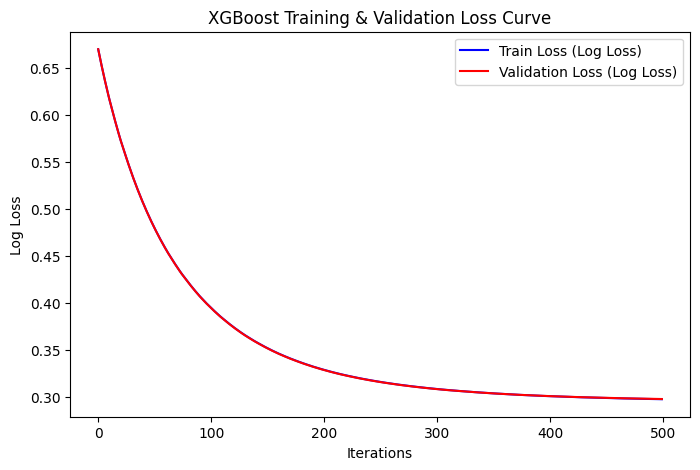

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91    283116
           1       0.92      0.17      0.28     69272

    accuracy                           0.83    352388
   macro avg       0.87      0.58      0.59    352388
weighted avg       0.85      0.83      0.78    352388



In [32]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

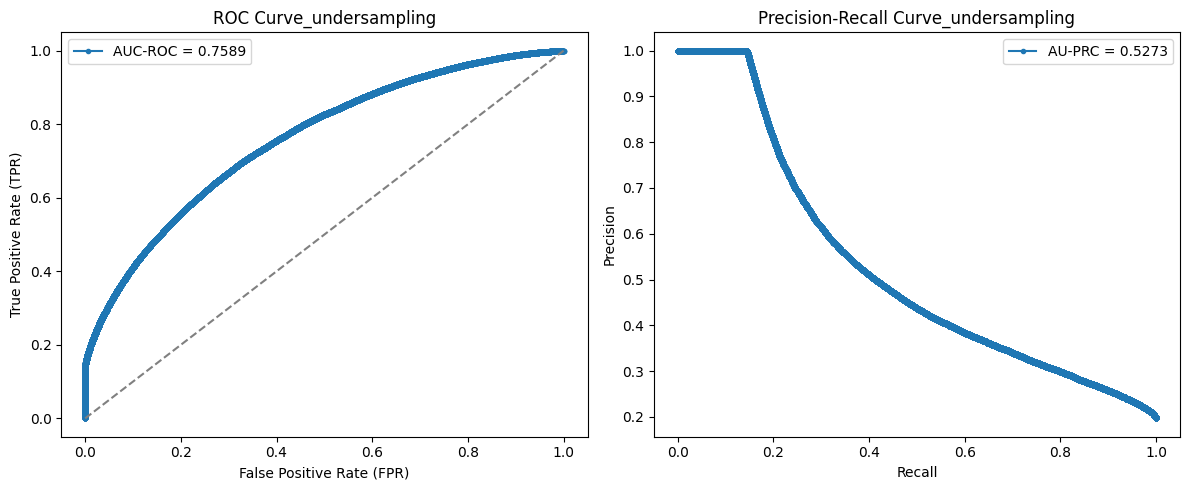

In [33]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

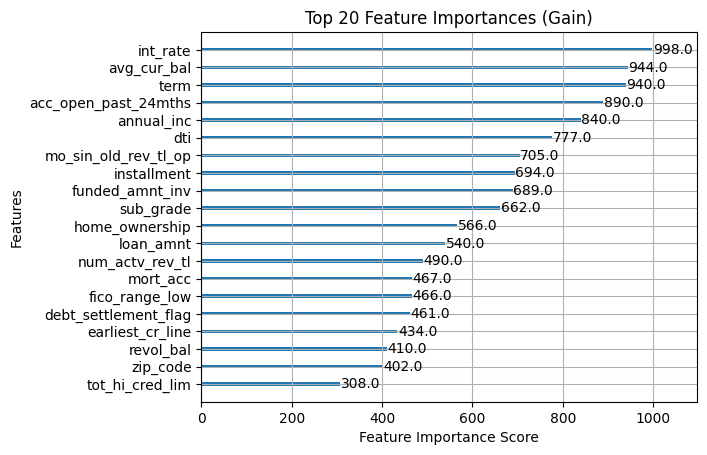

In [34]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()